# Exploration of Car Make and Violation Description Data from The City of Los Angeles Parking Citation Open Dataset

Based on [previous explorations](https://github.com/hackforla/lucky-parking/tree/citation-analysis/notebooks/exploratory) of the Los Angeles Parking Citation Open Dataset, it was found that parking citation violation types varied greatly by car make. This exploration will repeat that analysis and look at picking the best features for a model for users to interact with.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
from pathlib import Path
import random
import seaborn as sns

# Load project directory
PROJECT_DIR = Path(os.path.abspath('../..'))

In [89]:
# Load already cleaned data from makefile command
# 20% sampled from raw dataset
# Only make and violation_description columns
df = pd.read_csv(PROJECT_DIR / 'data' / 'processed' / '2021-01-02_processed_02samp.csv', index_col=0)
df.head()

,make,violation_description
index,,
0,Nissan,WHITE CURB
1,Acura,NaN
2,Nissan,NO STOP/STAND AM
3,Chrysler,NO STOP/STAND AM
4,Mercedes Benz,PREF PARKING


In [90]:
# Examine missing data
df.isna().sum()/len(df)*100

make                     0.085941
violation_description    0.187594
dtype: float64

The fraction of missing data is relatively small so we will drop it for now.

In [91]:
# Drop all missing data
df.dropna(inplace=True)

In [92]:
df.make.value_counts()[:10]

Toyota           387011
Honda            250103
Ford             191357
Nissan           159517
Chevrolet        151597
BMW              102069
Mercedes Benz     92266
Volkswagen        74731
Hyundai           68733
Dodge             65950
Name: make, dtype: int64

In [93]:
df.violation_description.value_counts()[:10]

NO PARK/STREET CLEAN      632971
METER EXP.                391677
RED ZONE                  181633
PREFERENTIAL PARKING      156101
DISPLAY OF TABS           129092
NO PARKING                 98019
STOP/STAND PROHIBIT        86330
PARKED OVER TIME LIMIT     70545
DISPLAY OF PLATES          61316
WHITE ZONE                 47264
Name: violation_description, dtype: int64

In [112]:
# Create table of violation ratio by make
def ratio_table(df, n=50):
  make_vio_dict = {}
  for make in df.make.value_counts().head(n).index:
    counts = df.loc[(df.make == make), 'violation_description'].value_counts()
    count_ratio = counts/counts.sum()
    make_vio_dict[make] = count_ratio.to_dict()
  dg = pd.DataFrame.from_dict(make_vio_dict).T.fillna(0)
  # Lets drop unknown and other car makes
  dg.drop(index=['Other', 'Unknown'], inplace=True)
  return dg

In [113]:
make_ratio = ratio_table(df, 65)

In [114]:
# Show table of violation ratios
make_ratio.head(10).style.background_gradient(cmap='Blues').format("{:.3f}")

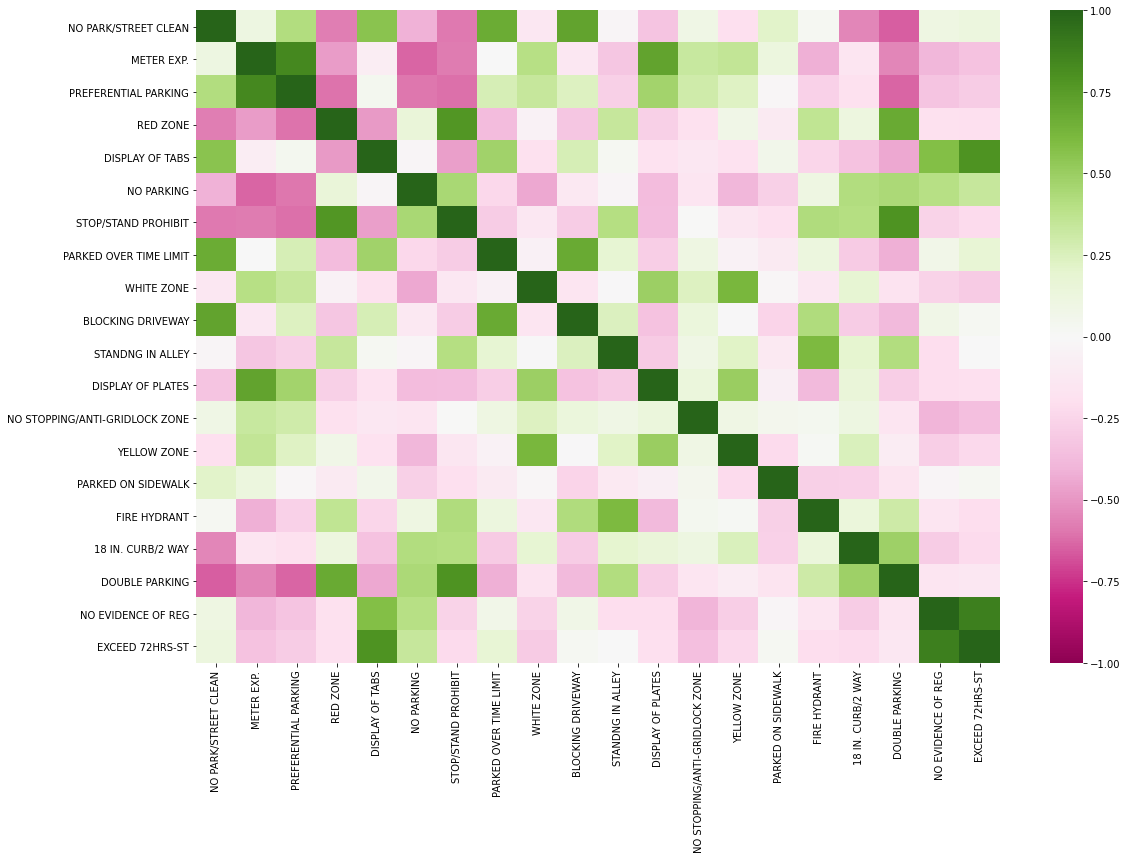

In [96]:
# Correlation heat map
plt.figure(figsize=(18,12))
sns.heatmap(make_ratio.iloc[:,:20].corr(), vmin=-1., vmax=1.,cmap='PiYG')
plt.show()

In the heat correlation map, green indicate high positive correlation and magenta colors indicate high negative correlation, while white and colors approaching white approach 0 or no correlation. One of the things that jump out the most are the green squares caused by "meter exp" and "preferential parking" as well as "stop/stand prohibit" and "no stop/stand". The latter two seem like two spellings for the same violation but during the data cleaning phase it was found that they have two different violation codes. That indicates that car makes that get a lot of red zone tickets will have lower relative amount of street cleaning, meter expiration, and preferential parking tickets. To further explore this relationship, principal component analysis can be done to see if there are natural axes of behavior contained in the data.

In [97]:
# Find principal component of violation ratio data using one component
pca = PCA(n_components=4)
make_pca = pd.DataFrame(data = pca.fit_transform(make_ratio)
             , columns = [f'Principal_Component_{n + 1}' for n in range(len(pca.components_))], index = make_ratio.index)
make_pca.head()

,Principal_Component_1,Principal_Component_2,Principal_Component_3,Principal_Component_4
Toyota,-0.058638,-0.040500,0.021715,-0.026338
Honda,-0.057337,-0.049598,0.018785,-0.019340
Ford,-0.024276,-0.049586,0.008900,-0.007303
Nissan,-0.031590,-0.041282,0.025825,-0.015577
Chevrolet,-0.016388,-0.045239,0.014671,-0.003295


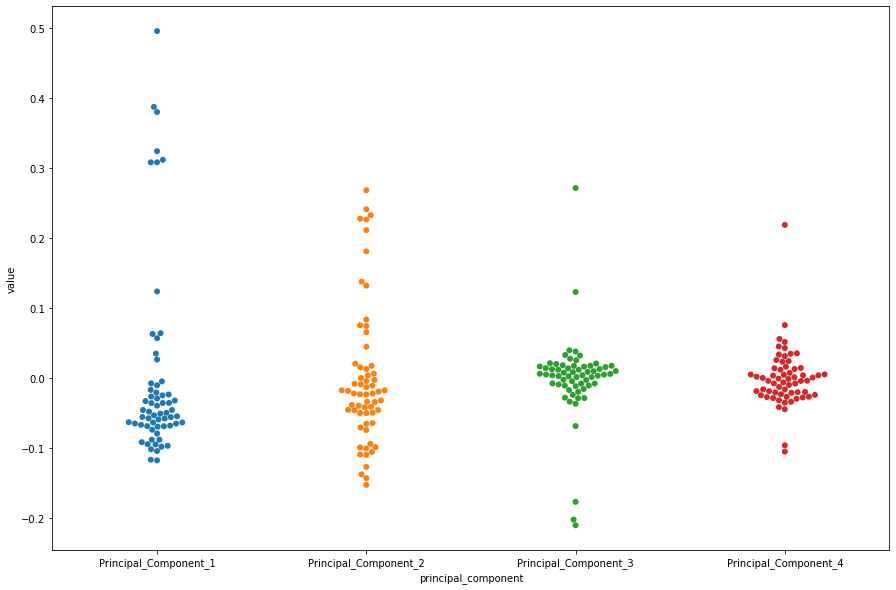

In [98]:
plt.figure(figsize=(15,10))
sns.swarmplot(x='principal_component' , y='value', data=pd.melt(make_pca.reset_index(), id_vars=['index'], var_name='principal_component'), size=6)
plt.show()

[]

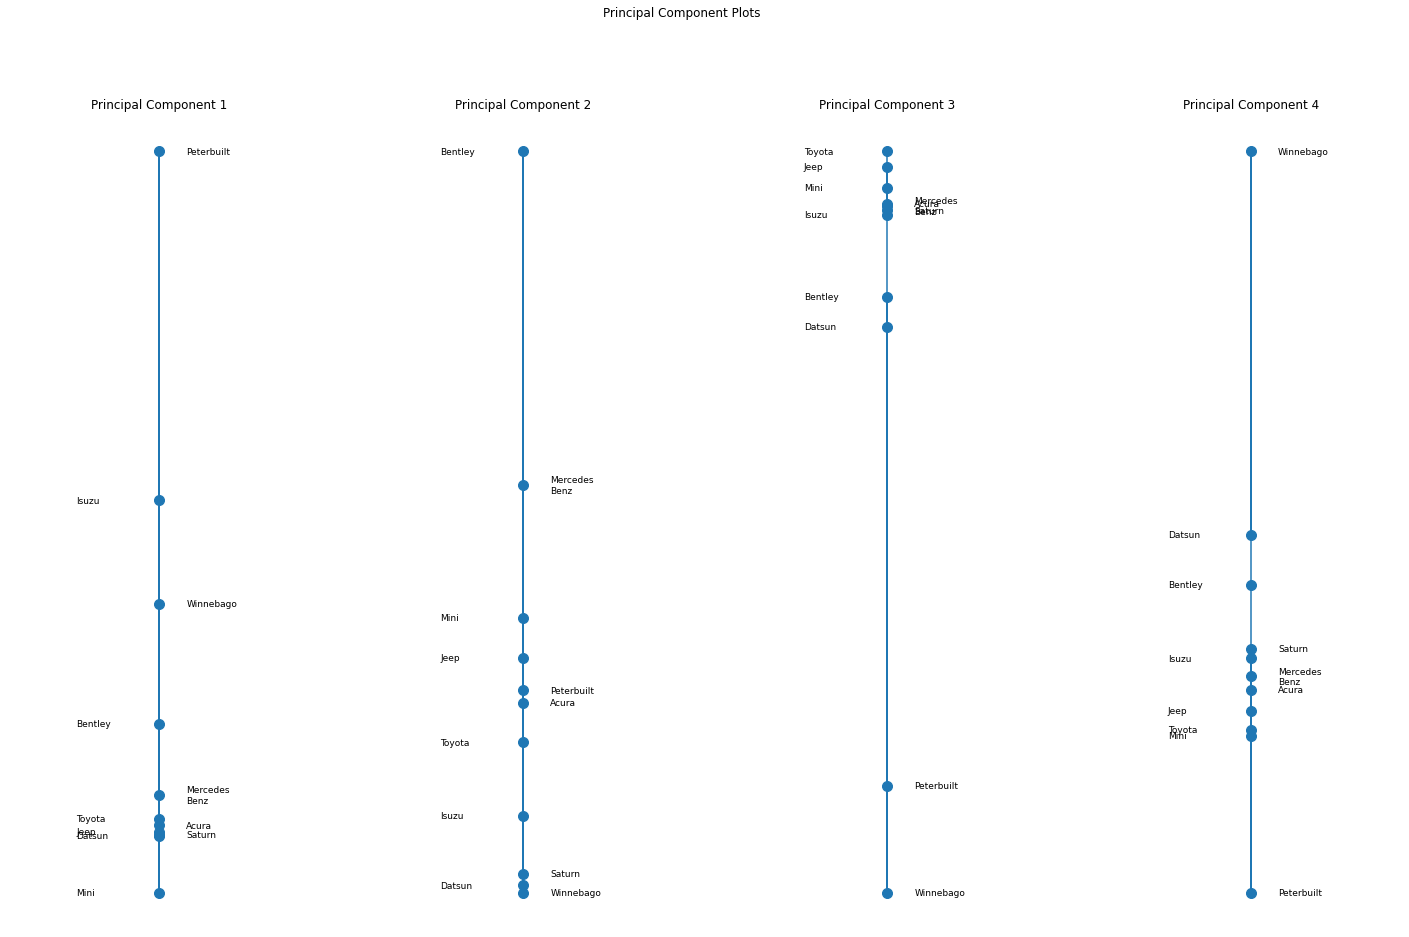

In [99]:
# Plot each make on each principal component
fig, axes = plt.subplots(1, len(pca.components_), figsize=(25,15))
fig.suptitle('Principal Component Plots')

for ind, ax in enumerate(axes):
    subset = make_pca.iloc[::6, ind]
    # Add line return to Mercedes Benz
    subset.rename(index={'Mercedes Benz': 'Mercedes\nBenz'}, inplace=True)
    ax.plot(np.zeros(len(subset)), subset, marker='.', markersize=20)
    ax.axis('off')
    ax.set_title(f'Principal Component {ind+1}')
    for i, txt in enumerate(subset.index):
        if i%2 == 0:
            ax.annotate(txt, (-0.03, subset.iloc[i]), fontsize=9, va='center')
        else: 
            ax.annotate(txt, (0.01, subset.iloc[i]), fontsize=9, va='center')

plt.plot()

In [100]:
# Print explained variance ratio
pca.explained_variance_ratio_

array([0.51419144, 0.27477517, 0.10032182, 0.04733286])

Here we can see that the first principal component can explain 51% of the variance and the second component can explain 29% of the variance. From there, the other two components are much less--9.6 and 4.3% respectively, with a combined variance of 94% being represented by these 4 components.

In [101]:
# Examine principal component weights
pca_components = pd.DataFrame(pca.components_, columns=make_ratio.columns, index=[f'PC_{n + 1}' for n in range(len(pca.components_))])
pca_components.style.background_gradient(cmap='Blues').format("{:.3f}")

,NO PARK/STREET CLEAN,METER EXP.,PREFERENTIAL PARKING,RED ZONE,DISPLAY OF TABS,NO PARKING,STOP/STAND PROHIBIT,PARKED OVER TIME LIMIT,WHITE ZONE,BLOCKING DRIVEWAY,STANDNG IN ALLEY,DISPLAY OF PLATES,NO STOPPING/ANTI-GRIDLOCK ZONE,YELLOW ZONE,PARKED ON SIDEWALK,FIRE HYDRANT,18 IN. CURB/2 WAY,DOUBLE PARKING,NO EVIDENCE OF REG,EXCEED 72HRS-ST,OFF STR/OVERTIME/MTR,OUTSIDE LINES/METER,EXPIRED TAGS,PARKED IN PARKWAY,DISABLED PARKING/NO DP ID,OVNIGHT PRK W/OUT PE,WHITE CURB,PRIVATE PROPERTY,METER EXPIRED,NO STOPPING/STANDING,PK IN PROH AREA,PARKED IN CROSSWALK,PREF PARKING,RESTRICTED TAXI ZONE,COMM VEH OVER TIME LIMIT,DISABLED PARKING/NO,PARKED IN BUS ZONE,HANDICAP/NO DP ID,CITY PARK/PROHIB,WITHIN INTERSECTION,SAFETY ZONE/CURB,PARKING/FRONT YARD,NO PARKING BETWEEN POSTED HOURS,BLK BIKE PATH OR LANE,OFF STR MTR/OUT LINE,18 IN. CURB/1 WAY,DSPLYPLATE A,STNDNG IN ALLEY,NO STOP/STAND PM,GREEN ZONE,PARKED IN FIRE LANE,PKD OVER TIME LIMIT,PARKING OUTSIDE PARKING STALLS,RED CURB,DP-BLKNG ACCESS RAMP,DP- RO NOT PRESENT,DISABLED PARKING/CROSS HATCH,NO STOP/STAND AM,3 FT. SIDEWALK RAMP,TIME LIMIT/CITY LOT,PARK IN GRID LOCK ZN,18 IN/CURB/COMM VEH,PARKING AREA,WRG SD/NOT PRL,CARSHARE PARKING,DISABLED PARKING/CRO,ELECTRIC CHARGING STATION SPACES,PKD IN/ON PARKWAY,SIGN POSTED - NO PARKING,OVERNIGHT PARKING,LOAD/UNLOAD ONLY,EXCEED 72 HOURS,EXCEED TIME LMT,DISABLED PARKING/OBSTRUCT ACCESS,PARK-PSTD AREAS,PRK IN ELEC VEH SPACE,PK OUTSD SPACE,RED FLAG DAY,PK OTSD PSTD AR,PUBLIC GROUNDS,CLEANING VEH/STREET,R/PRIV PARKING AREA,PARKING/FRONT YARD 1,HANDICAP/CROSS HATCH,HANDICPD/BLOCKING,DISABLED PARKING/OBS,DISABLED PARKING/BOUNDARIES,AUDIBLE ALARM,HANDICAP/ON LINE,OBST FIRE RD,PK OVR PNTD LNS,PK OVERSIZ,DP-REFUSE ID,ILGL EXT OF TM,STORING VEH/ON STR,PERIOD OF DISPLAY,PARK FIRE LANE,RESTRICTED ZONE,PK-15FT FIRE ST,PARKING PROHIB,BLOCKING INTERSECTION,REPAIRING VEH/STREET,BLOCK HANDICAP ACCES,NO COIN DEP IN METER,2251157C,DP-SUBPLATE,OVERSIZED VEHICLE PARKING TOPHAM ST,PARK RED FLAG DAY,STOP/STAND PROHB,IN PARK AFT HRS,22523B,ON RR TRACK/7.5 FT,PRKG PUBL GRNDS,FOR SALE SIGN,DP-ALTERED,LEFT SIDE OF ROADWAY,PK OVR 2 SPACES,W/I 25 FT. CROSSWALK,RGSTR CARD RQD,BICYCLE PARKING,5002,6FT OF RR TRACK,FAIL DEP COIN,METER OFFENSE,PARK IN XWALK,8755*,PK VEH SALE/RNT,PK ON PRIV ST,PARK RESTRCD,MORE 18-CURB,RESTRCTD ZONES,PK OVERSIZED 1ST,2251157,COMM TRAILER/22 FT.,UNATT/MOTOR ON,PARKED ON BRIDGE,HANDICPD/ON LINE,LOADING ZONES,PARKING OUTSIDE OF S,ABAND VEH/PUB/PRIV,FRONT BUMP REQ,PARALLEL PK RQD,COMVEH RES/OV TM LMT,VIO-PERM/PARK,RV-OVERNIGHT,PARKING/FRONT YARD 3,PK TRAILER,OUTSIDE MARKER,FR FORGN JURIS,OBSTR EXCAVATN,COMMERCIAL - UNDESIG,STATE HIGHWAY PARKNG,4464,OFF STREET/OVERTIME,DSPLYPLATE B,MISUSE/DP PRIVILEGE,VEH/LOAD OVR 6' HIGH,COMVEH RES/OV TM C-3,ADVERTISING ON VEH,COMVEH RES/OV TM B-2,HAZARDOUS AREA,OFF STR MTR/NO COIN,8755**,PK OVERSIZED 3RD,PK OVERSIZED 2ND,WRG VEH REGISTR,8054,PARK NEAR EMERG VEH,PARKING/FRONT YARD 2,STANDING IN ALLEY,PK NR FIRE HYDR,PK BYND TM LMTS,TEMPORARY NO PARKING,22500J,POSITION OF PLATES,21461,MT FIRE RD NO PERMIT,ABAND VEH/HIGHWAY,PK TRLR-PUBL AR,PARKED IN ELEC VEHICLE SPACE,NO PARK STRT CLEAN,YELLOW CURB,DOUBLE PARK,BLK INT PROHIB,CATERING VIOLATION,PARK LOT - STRT/ALY,MOB BILBD ADV DISP,UNINCORP AREA,ANGLE PKD,TRAILER 6' HIGH,VIOL EMER RULES
PC_1,-0.610,-0.374,-0.161,0.528,-0.116,0.092,0.222,-0.052,-0.010,-0.018,0.014,-0.078,-0.005,-0.001,-0.013,0.007,0.016,0.179,-0.008,-0.012,-0.011,-0.001,0.001,-0.012,-0.004,-0.003,-0.001,-0.001,-0.001,0.001,0.001,0.000,-0.002,0.007,0.239,-0.001,0.006,-0.002,-0.002,0.000,-0.002,-0.001,0.001,0.019,-0.001,0.004,-0.002,-0.000,-0.000,-0.000,0.002,0.000,-0.001,-0.000,0.001,-0.001,-0.001,0.001,0.000,-0.000,0.000,0.099,-0.001,0.003,-0.000,-0.001,-0.000,-0.000,0.000,0.004,-0.000,0.000,0.000,-0.000,0.002,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.001,-0.000,0.000,0.001,-0.000,-0.001,-0.000,0.000,0.010,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000

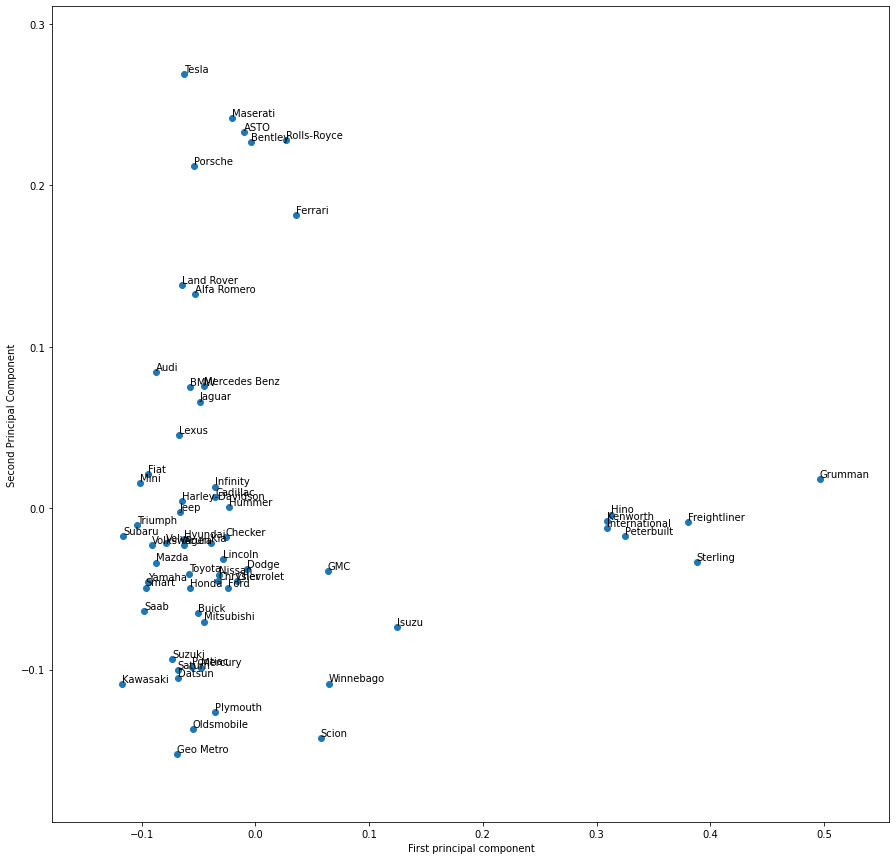

In [102]:
# PCA 2-component plot
plt.figure(figsize=(15,15))
plt.scatter(make_pca.iloc[:,0],make_pca.iloc[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.margins(0.1)
for i, txt in enumerate(make_pca.index):
    plt.annotate(txt, (make_pca.iloc[i,0], make_pca.iloc[i,1]), fontsize=10, va='bottom')
plt.show()

In [103]:
# Breakdown of the highest violation weight in each principal component
pd.DataFrame({'Major Violation Component': pca_components.apply(lambda x: x.idxmax(), axis=1).to_list() ,'Weight Fraction': pca_components.max(axis=1)})

,Major Violation Component,Weight Fraction
PC_1,RED ZONE,0.528220
PC_2,METER EXP.,0.645870
PC_3,RED ZONE,0.715772
PC_4,NO EVIDENCE OF REG,0.377677



If we were to build a model with the fewest amount of features, instead of just picking the highest weights we would pick the highest absolute value weights and throw out any other weights that are close to zero. Each principal component reflects real life spectrums of human behavior. The first positive and negative weights are often the best clues to understanding what each principal component is made up of.

In [104]:
pca_components.loc['PC_1'].sort_values(ascending=False, key=abs)[:10]

NO PARK/STREET CLEAN       -0.609959
RED ZONE                    0.528220
METER EXP.                 -0.374169
COMM VEH OVER TIME LIMIT    0.239397
STOP/STAND PROHIBIT         0.222151
DOUBLE PARKING              0.179124
PREFERENTIAL PARKING       -0.160917
DISPLAY OF TABS            -0.116345
18 IN/CURB/COMM VEH         0.098824
NO PARKING                  0.091863
Name: PC_1, dtype: float64

The principal components are ordered by highest variance, which makes data points on the opposite sides of this scale the easiest to differentiate via their parking behavior. In the 2D plot above, it can be seen that the Suburu and the Grumman are on opposite sides of the first principal component. According to the listed component weights, the Grumman, has a very high number of red zone parking tickets and very few street cleaning tickets, and vice versa for the Suburu. Since the most popular Grumman vehicle is a US Postal Service truck and California enforces its parking laws even on the USPS, this is very much possible. Looking at the 2D plot, it becomes very obvious that this principal component separates out passenger vehicle citations from the commercial vehicle citations.

In [105]:
# Sort of components of second component by absolute value
pca_components.loc['PC_2'].sort_values(ascending=False, key=abs)[:10]

METER EXP.                0.645870
NO PARK/STREET CLEAN     -0.553464
DISPLAY OF PLATES         0.451449
DISPLAY OF TABS          -0.140233
PREFERENTIAL PARKING      0.129582
NO EVIDENCE OF REG       -0.085874
EXCEED 72HRS-ST          -0.081081
NO PARKING               -0.065167
RED ZONE                 -0.061540
PARKED OVER TIME LIMIT   -0.059724
Name: PC_2, dtype: float64

Here we can see that principal component 2 has its main component being meter expiration but street cleaning violations are negatively correlated, meaning car makes that score higher along this axis have less street sweeping and more meter expiration and display of plate violations. Also, the top offender is Tesla, followed by other luxury brand car makes and ends with some more affordable domestic car makes. This could reflect the parking behavior of people who drive luxury cars vs more affordable cars--people who drive luxury cars are more likely to park their car off the public streets, either because they have a garage or live somewhere with allocated parking.


In [106]:
pca_components.loc['PC_3'].sort_values(ascending=False, key=abs)[:10]

RED ZONE                    0.715772
COMM VEH OVER TIME LIMIT   -0.411557
NO PARK/STREET CLEAN        0.289024
NO PARKING                 -0.251887
METER EXP.                  0.244114
NO EVIDENCE OF REG         -0.160980
EXCEED 72HRS-ST            -0.152687
DISPLAY OF TABS            -0.143648
DISPLAY OF PLATES          -0.086141
PREFERENTIAL PARKING        0.083370
Name: PC_3, dtype: float64

What we find in PCA_3 is the inclusion of a lot of commercial vehicle specific citations. In contrast to the first principal component which also addressed commercial vehicles, there is an inverse relationship between red zone citations and commercial vehicle over time limit citations. There are other positive weights regarding citations for not parking near the curb at all. This particular component might be differentiating between commercial vehicles that park at the curb to do deliveries and commercial vehicles that unload a lot of material over long periods of time, like moving trucks that perhaps park in the middle of the street

In [107]:
pca_components.loc['PC_4'].sort_values(ascending=False, key=abs)[:10]

COMM VEH OVER TIME LIMIT   -0.521321
NO EVIDENCE OF REG          0.377677
EXCEED 72HRS-ST             0.368561
DISPLAY OF TABS             0.360326
DISPLAY OF PLATES           0.287336
STOP/STAND PROHIBIT        -0.225989
METER EXP.                 -0.206047
NO PARK/STREET CLEAN       -0.200120
PREFERENTIAL PARKING       -0.144427
18 IN/CURB/COMM VEH        -0.136458
Name: PC_4, dtype: float64

In the fourth principal component the positive weights have to deal with display of plates/tabs and other citations associated with abandoned cars, while the negative weights have to do with regular parking regulations like preferential parking, commercial vehicles over time limit, and meter expiration. In the 2D graph, there doesn't seem to be a specific luxury car vs non-luxury car make grouping here as both Porsche and Pontiac are both bad offenders. One interpretation is that this component shows the people who drives either Porsches and Pontiacs to either not display up to date plates or tags due to privacy reasons or economic reasons. It is such a common phenomenon for people not to display plates for privacy reasons, which people usually do by leaving the temporary dealer plates on permanently, that the state of Caliornia recently had to change the law banning it and requiring temporary, paper license plates. Or, it is because these cars either breakdown often and/or repair costs are so high that many people allow their cars to become non-operational and stop updating their plates/tabs/registration.

Based on what was observed in the breakdown of the top 4 principal components, it would be useful to plot the two passenger car related components against each other and the two commercial vehicle related components together.

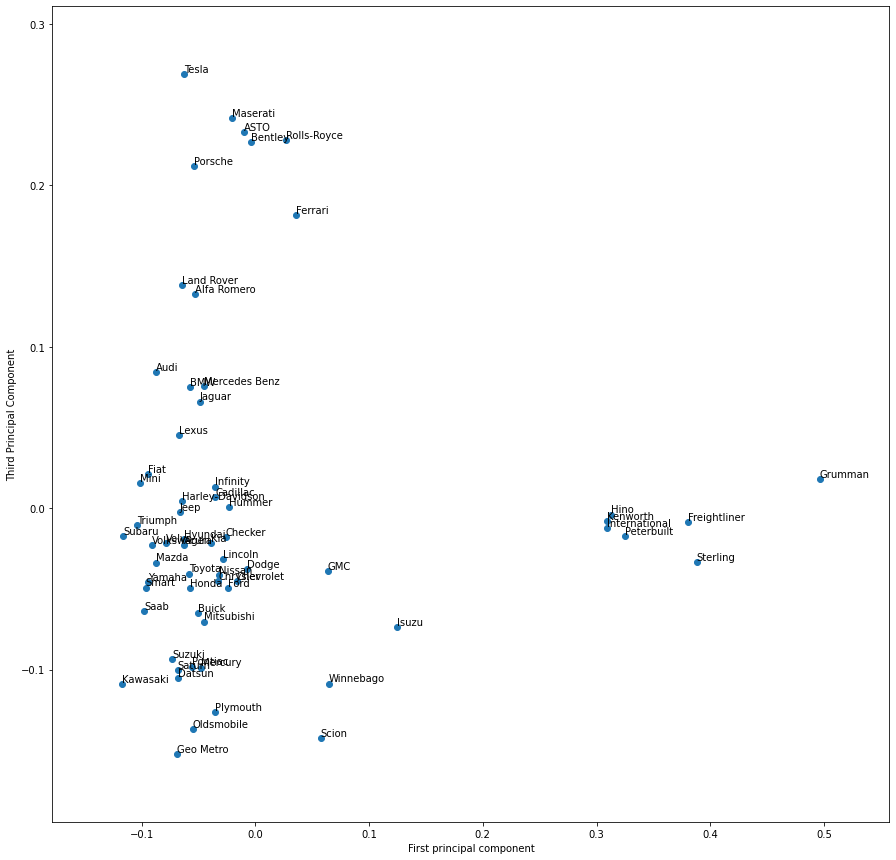

In [108]:
# PCA 2-component plot
plt.figure(figsize=(15,15))
plt.scatter(make_pca.iloc[:,0],make_pca.iloc[:,1])
plt.xlabel('First principal component')
plt.ylabel('Third Principal Component')
plt.margins(0.1)
for i, txt in enumerate(make_pca.index):
    plt.annotate(txt, (make_pca.iloc[i,0], make_pca.iloc[i,1]), fontsize=10, va='bottom')
plt.show()

By plotting the two commercial vehicle related principal components against each other, we find that the passenger cars are all clumped together whereas the commercial makes are spread out. At the top are larger commercial trucks and at the bottom right are US Postal Service vehicles.

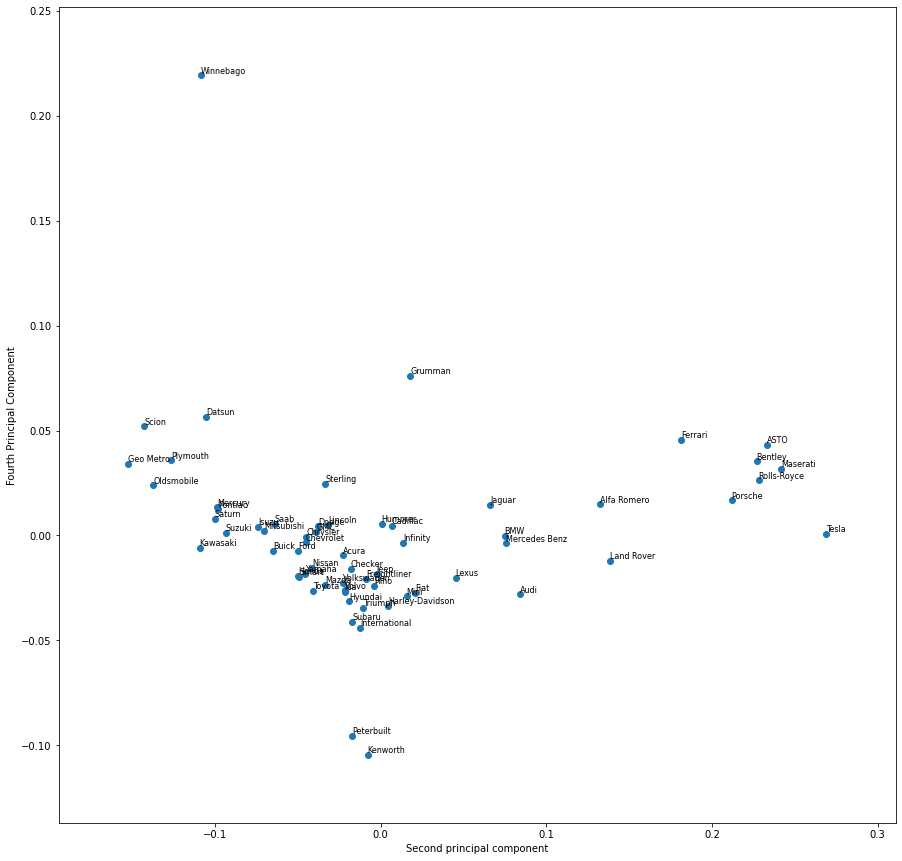

In [109]:
# PCA 2-component plot
plt.figure(figsize=(15,15))
plt.scatter(make_pca.iloc[:,1],make_pca.iloc[:,3])
plt.xlabel('Second principal component')
plt.ylabel('Fourth Principal Component')
plt.margins(0.1)
for i, txt in enumerate(make_pca.index):
    plt.annotate(txt, (make_pca.iloc[i,1], make_pca.iloc[i,3]), fontsize=8, va='bottom')
plt.show()

Plotting the second and fourth principal components gives a very nice dispersion of all the car makes. At the top there seems to be a divide between Pontiac, Mercury, Jaguar, Saturn, and Porsche vs the rest. At the right there seems to be a divide between Porsche and Tesla and the rest. As we approach the top right, car makes tend to have less street sweeping tickets and more tickets that are associated with luxury cars. At the top left, there are cars that get more street sweeping tickets and unregistered plates/tabs, which might indicate these cars being abandoned.

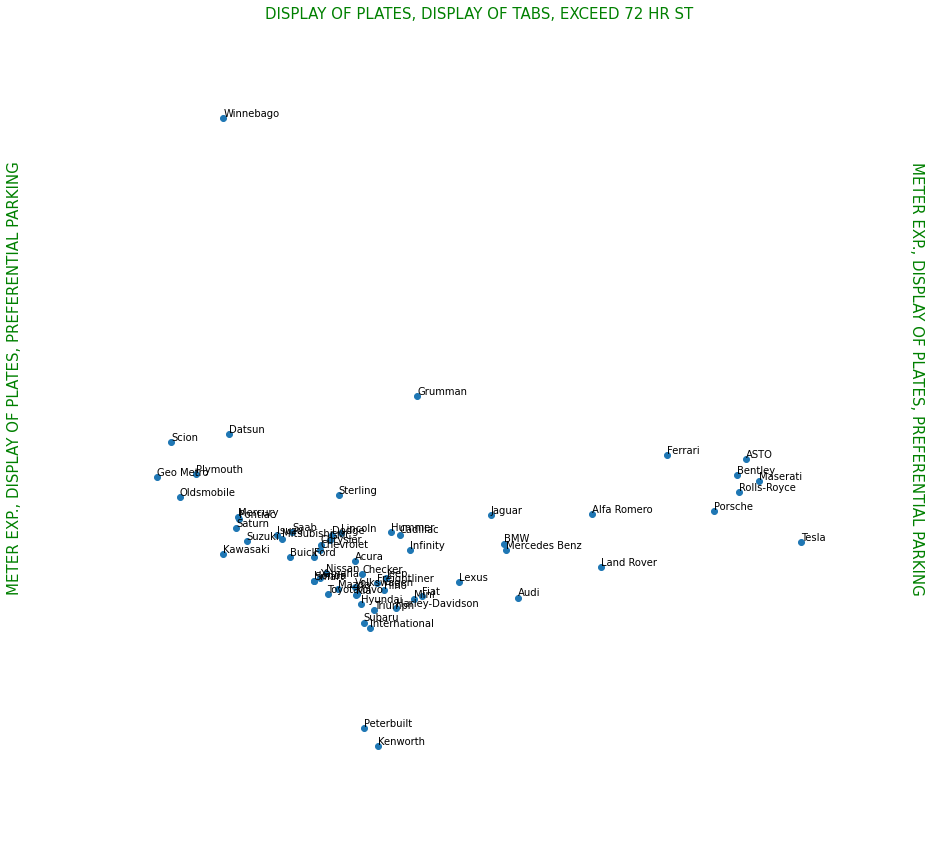

In [110]:
# PCA 2-component plot
plt.figure(figsize=(15,15))
plt.scatter(make_pca.iloc[:,1],make_pca.iloc[:,3])
# plt.ylabel('NO PARK/STREET CLEAN, DISPLAY OF TABS', color='red', fontsize=15)
plt.title('DISPLAY OF PLATES, DISPLAY OF TABS, EXCEED 72 HR ST', color='green', fontsize=15)
# plt.xlabel('PREFERENTIAL PARKING, COMM VEH OVER TIME LIMIT, METER EXP.', color='red', fontsize=15)
plt.margins(0.1)
plt.axis('off')
for i, txt in enumerate(make_pca.index):
    plt.annotate(txt, (make_pca.iloc[i,1], make_pca.iloc[i,3]), fontsize=10, va='bottom')

plt.text(0.34,-.025, 'METER EXP., DISPLAY OF PLATES, PREFERENTIAL PARKING', rotation=-90,
        color='green', fontsize=15)
plt.text(-0.25,-.025, 'METER EXP., DISPLAY OF PLATES, PREFERENTIAL PARKING', rotation=90,
        color='green', fontsize=15)
plt.margins(0.15)
plt.show()